# The Machinery

In [2]:
import numpy as np
import theano as theano
import theano.tensor as T

/home/hudson/.local/lib/python3.5/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda0: GeForce GTX 1080 (0000:02:00.0)


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import sys
sys.path.append('/home/hudson/Projects/GAMM')
from lib.utils import log_progress

In [5]:
class Hidden(object):
    #http://deeplearning.net/tutorial/mlp.html
    def __init__(self, input, n_in, n_out, W = None, b = None,
                 activation = T.tanh, rng = np.random.RandomState()):
        
        self.input = input
        
        if W is None:
            W_range = np.sqrt(6. / (n_in + n_out))
            W_values = np.asarray(
                rng.uniform(
                    low = -W_range,
                    high = W_range,
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == T.nnet.sigmoid:
                W_values *= 4
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b
        
        # parameters of the model
        self.params = [self.W, self.b]
        
        lin_output = T.dot(input, self.W) + self.b
        self.out = (
            lin_output if activation is None
            else activation(lin_output)
        )

In [6]:
def decision(X, model, h=.05):
    # X - some data in 2dimensional np.array
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = model(np.c_[xx.ravel(), yy.ravel()]) 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    #plt.axis('off')

## Gaussian


In [7]:
class Gaussian(object):
    def __init__(self, ndim=2, mu=None, cov=None, scale=1):
        if mu is None:
            mu = scale*np.random.randn(ndim,)
            
        if cov is None:
            cov = np.random.randn(ndim, ndim)
            cov = np.dot(cov, cov.T)
            
        self.mu = mu.astype(theano.config.floatX)
        self.cov = cov.astype(theano.config.floatX)
        
        ndim = mu.shape[0]
        self.ndim = ndim
        
    def fit(self, x):
        self.mu = x.mean(axis=0)
        self.cov = np.cov(x.T)
        
    def sample(self, n=1):
        return(np.random.multivariate_normal(self.mu, self.cov, n)
                  .astype(theano.config.floatX))

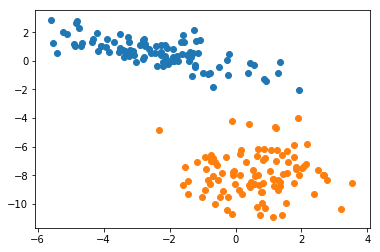

In [8]:
g1 = Gaussian(2, scale=5)
z1 = g1.sample(100)

g2 = Gaussian(2, scale=5)
z2 = g2.sample(100)

plt.scatter(z1[:,0], z1[:,1])
plt.scatter(z2[:,0], z2[:,1])

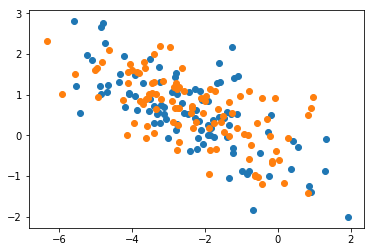

In [9]:
g2.fit(z1)
z2 = g2.sample(100)

plt.scatter(z1[:,0], z1[:,1])
plt.scatter(z2[:,0], z2[:,1])

## Mixture


In [10]:
class Mixture(object):
    def __init__(self, k = 3, ndim = 2, p = None):
        self.k = k
        self.gaussians = np.array([Gaussian(ndim=ndim, scale = k**2) for i in range(k)])
        self.p = np.ones(k)/k if p is None else p
        
    def sample(self, n=1):
        out = np.vstack([self.gaussians[i].sample(int(n * self.p[i])) for i in range(self.k)])
        return(out)

In [11]:
m = Mixture(2)

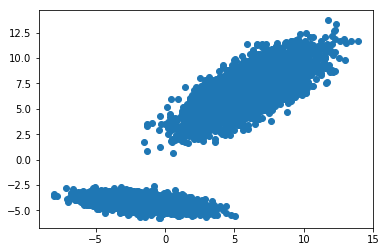

In [12]:
gx = m.sample(10000)
plt.scatter(gx[:,0], gx[:,1])

In [13]:
class MLP(object):
    def __init__(self, input, n_in=2, n_out=2, n_hidden=300, params = None,
                 rng = np.random.RandomState()):
        self.input = input
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.rng = rng
        
        hidden = Hidden(
            input,
            n_in, n_hidden,
            W = None if params is None else params[0],
            b = None if params is None else params[1],
            rng = rng
        )
        self.hidden = hidden
        
        out = LogisticRegression(
            self.hidden.out,
            n_hidden, n_out,
            W = None if params is None else params[2],
            b = None if params is None else params[3],
            rng = rng
        )
        self.out = out
        
        self.lin = out.lin
        self.p_y = out.p_y
        self.y_pred = out.y_pred
        
        self.params = hidden.params + out.params
        
    def predict(self, x):
        mlp = MLP(x, self.n_in, self.n_out, self.n_hidden, self.params, self.rng)
        return(mlp.y_pred.eval())
    
    def prob(self, x, temp = 1):
        mlp = MLP(x, self.n_in, self.n_out, self.n_hidden, self.params, self.rng)
        return(T.nnet.softmax(mlp.lin / temp).eval())
    
    def forward(self, z):
        gen = MLP(z, n_in=self.n_in, n_out=self.n_out, n_hidden=self.n_hidden,
                        params = self.params, rng = self.rng)
        return(gen.lin.eval())

In [14]:
z1 = Gaussian(2, scale=5).sample(1000)
z2 = Gaussian(2, scale=5).sample(1000)
gen1 = MLP(z1, n_hidden = 200)
gen2 = MLP(z1, n_hidden = 200,  params = gen1.params)

gX1 = gen1.lin.eval()
gX2 = gen2.forward(z2)

plt.scatter(z1[:,0], z1[:,1], label = 'z1')
plt.scatter(gX1[:,0], gX1[:,1], label = 'g1')

plt.scatter(z2[:,0], z2[:,1], label = 'z2')
plt.scatter(gX2[:,0], gX2[:,1], label = 'g2')

plt.legend()

NameError: name 'LogisticRegression' is not defined

##### Distribution to fit

In [ ]:
from sklearn.datasets import make_moons

In [ ]:
x, y = make_moons(1000, noise=.1)
# g = Gaussian(2)
# x = g.sample(1000)
#x = x[np.where(y == 1)]

In [ ]:
plt.scatter(x[:,0], x[:,1])

### Model fitting

In [ ]:
def Adam(cost, params, lr=0.0002, b1=0.9, b2=0.999, e=1e-8, c=None):
    #https://gist.github.com/Newmu/acb738767acb4788bac3
    #Standard literature says b1=.9
    #DCGAN paper says b1 = .5
    b1 = 1-b1
    b2 = 1-b2
    updates = []
    grads = T.grad(cost, params)
    i = theano.shared(np.float32(0.))
    i_t = i + 1.
    fix1 = 1. - (1. - b1)**i_t
    fix2 = 1. - (1. - b2)**i_t
    lr_t = lr * (T.sqrt(fix2) / fix1)
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        p_t = p - (lr_t * g_t) if c is None else T.clip(p - (lr_t * g_t), -c, c)
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    updates.append((i, i_t))
    return updates

def RMSprop(cost, params, lr=0.00005, rho=0.99, epsilon=1e-8, c=None):
    #https://github.com/Newmu/Theano-Tutorials
    #rho = .99 is torch default, used in paper
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        update = p - lr * g if c is None else T.clip(p - lr * g, -c, c)
        updates.append((p, update))
    return updates

def gradDesc(cost, params, lr=.00005):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        update = p - lr * g
        updates.append((p, update))
    return updates

# Standard GAN

In [ ]:
def trainGAN(X, batch_size = 100, iters = 10000, alpha = .005, prior_dim = 2, gen_hidden = 300,
             disc_hidden = 500,
             rng = np.random.RandomState()):
    
    #Model building
    print("Building model...")
    
    x = T.matrix('x')
    z = T.matrix('z')
    
    n_dim = X.shape[1]
    
    prior = Gaussian(prior_dim)
    
    gen = Generator(z, n_in=prior_dim, n_hidden=gen_hidden, n_out=n_dim)
    gen_params = gen.params
    
    disc_data = MLP(x, n_in=X.shape[1], n_out=2, n_hidden=disc_hidden)
    disc_params = disc_data.params
    disc_gen = MLP(gen.out, n_in=X.shape[1], n_out=2, n_hidden=disc_hidden, params=disc_params)
    
    #Loss
    disc_loss = -(T.mean(T.log(disc_data.p_y[:, 0])) \
                  + T.mean(T.log(disc_gen.p_y[:, 1])))
    gen_loss = T.mean(T.log(disc_gen.p_y[:, 1]))
    
    #Updates
    disc_updates = Adam(disc_loss, disc_params, lr=alpha)
    gen_updates = Adam(gen_loss, gen_params, lr=alpha)
    
    #Training functions
    train_disc = theano.function(
        inputs = [x,z],
        outputs = disc_loss,
        updates = disc_updates)
    
    train_gen = theano.function(
        inputs = [z],
        outputs = gen_loss,
        updates = gen_updates
    )
    
    #Training loop 
    print("\nBegin training...")
    
    #Plot of initial model
    plt.figure()
    gX = gen.forward(prior.sample(X.shape[0]))
    plt.scatter(X[:,0], X[:,1], label = "Observed")
    plt.scatter(gX[:,0], gX[:,1], alpha = .4, label = 'Generated')
    plt.legend()
    plt.show()
    
    #Train
    disc_losses = []
    gen_losses = []
    for i in log_progress(range(iters), every = 10, name = "Iteration"):
        loss_disc = train_disc(
            X[rng.randint(X.shape[0], size=batch_size)],
            prior.sample(batch_size).astype(theano.config.floatX)
        )
        loss_gen = train_gen(
            prior.sample(batch_size).astype(theano.config.floatX)
        )
        disc_losses.append(loss_disc)
        gen_losses.append(loss_gen)
    #Plot of errors
    plt.figure()
    plt.plot(disc_losses)
    plt.plot(gen_losses)
    
    #Plot of final model
    plt.figure()
    gX = gen.forward(prior.sample(X.shape[0]))
    
    #decision(np.vstack((X,gX)), disc_data.predict)
    plt.scatter(X[:,0], X[:,1], label = "Observed")
    plt.scatter(gX[:,0], gX[:,1], alpha = .4, label = 'Generated')  
    plt.legend()
    plt.show()

In [ ]:
trainGAN(x.astype(theano.config.floatX))

# WGAN

In [ ]:
def trainWGAN(X, batch_size = 100, iters = 10000, alpha = .00005, prior_dim = 2, gen_hidden = 300,
             disc_hidden = 500, c = .1, n_crit = 5,
             rng = np.random.RandomState()):
    
    #Model building
    print("Building model...")
    
    x = T.matrix('x')
    z = T.matrix('z')
    
    n_dim = X.shape[1]
    
    prior = Gaussian(prior_dim)
    
    gen = Generator(z, n_in=prior_dim, n_hidden=gen_hidden, n_out=n_dim)
    gen_params = gen.params
    
    disc_data = MLP(x, n_in=X.shape[1], n_out=2, n_hidden=disc_hidden)
    disc_params = disc_data.params
    disc_gen = MLP(gen.out, n_in=X.shape[1], n_out=2, n_hidden=disc_hidden, params=disc_params)
    
    #Loss
    disc_loss = -(T.mean(disc_data.lin[:, 0]) \
                  - T.mean(disc_gen.lin[:, 1]))
    gen_loss = -T.mean(disc_gen.lin[:, 1])
    
    #Updates
    disc_updates = RMSprop(disc_loss, disc_params, lr=alpha, c=c)
    gen_updates = RMSprop(gen_loss, gen_params, lr=alpha)
    
    #Training functions
    train_disc = theano.function(
        inputs = [x,z],
        outputs = disc_loss,
        updates = disc_updates)
    
    train_gen = theano.function(
        inputs = [z],
        outputs = gen_loss,
        updates = gen_updates
    )
    
    #Training loop 
    print("\nBegin training...")
    
    #Plot of initial model
    plt.figure()
    gX = gen.forward(prior.sample(X.shape[0]))
    plt.scatter(X[:,0], X[:,1], label = "Observed")
    plt.scatter(gX[:,0], gX[:,1], alpha = .4, label = 'Generated')
    plt.legend()
    plt.show()
    
    #Train
    disc_losses = []
    for i in log_progress(range(iters), every = 10, name = "Iteration"):
        itercrit = n_crit * 20 if i < 25 or i % 500 == 0 else n_crit
        for b in range(itercrit):
            loss_disc = train_disc(
                X[rng.randint(X.shape[0], size=batch_size)],
                prior.sample(batch_size).astype(theano.config.floatX)
            )
        loss_gen = train_gen(
            prior.sample(batch_size).astype(theano.config.floatX)
        )
        disc_losses.append(-loss_disc)
    #Plot of errors
    plt.figure()
    plt.plot(disc_losses)
    
    #Plot of final model
    plt.figure()
    gX = gen.forward(prior.sample(X.shape[0]))
    
    #decision(np.vstack((X,gX)), disc_data.predict)
    plt.scatter(X[:,0], X[:,1], label = "Observed")
    plt.scatter(gX[:,0], gX[:,1], alpha = .4, label = 'Generated')  
    plt.legend()
    plt.show()

In [ ]:
trainWGAN(x.astype(theano.config.floatX), iters = 5000, n_crit = 5, c = 1, alpha = .005)

# GAMM

In [ ]:
def train(X, n_hidden = 500,
         batch_size = 100, iters = 400, alpha = .0005,
         rng = np.random.RandomState()):
    
    x = T.matrix('x')
    z = T.matrix('z')

    ndim = X.shape[1]    
    #prior = Mixture(2, 2)
    prior = Gaussian(2)
    
    print("Building model...")
    ################### Generator ###################
    
    gen = Generator(z, n_in=2, n_hidden=n_hidden, n_out=2)
    genParams = gen.params
    genCrit = MLP(gen.out, ndim, 2, n_hidden = n_hidden)
    critParams = genCrit.params
    realCrit = MLP(x, ndim, 2, n_hidden = n_hidden, params = critParams)

    critLoss = -T.mean(T.log(realCrit.p_y[:,0])) \
                -T.mean(T.log(genCrit.p_y[:,1]))
    
    genLoss = T.mean(T.log(genCrit.p_y[:,1]))
    
    critUpdates = Adam(critLoss, critParams, lr=alpha)
    genUpdates = Adam(genLoss, genParams, lr=alpha)
    
    trainGen = theano.function(
        inputs = [z], 
        outputs = genLoss, 
        updates = genUpdates
    )
        
    trainCrit = theano.function(
        inputs = [x,z], 
        outputs = critLoss, 
        updates = critUpdates
    )
        
    #################################################
    print("Done!")
    
    print('Begin training...')
    
    critPlot = []
    for iter in log_progress(range(iters), every=100):
        #gen/crit
        xG = X[rng.randint(X.shape[0], size=batch_size)]
        critPlot.append(-trainCrit(xG,
                                  prior.sample(batch_size).astype(theano.config.floatX)))
        trainGen(prior.sample(batch_size).astype(theano.config.floatX))
        
        if iter % 50000 == 0 or iters < 50000 and iters % 5000 == 0 :
            #Plot of final model
            plt.figure()
            gX = gen.forward(prior.sample(X.shape[0]))

            #decision(np.vstack((X,gX)), disc_data.predict)
            plt.scatter(X[:,0], X[:,1], label = "Observed")
            plt.scatter(gX[:,0], gX[:,1], alpha = .4, label = 'Generated')  
            plt.legend()
            plt.show()
    
    
    
    
    #Plot of errors
    plt.figure()
    plt.plot(critPlot)
    
    #Plot of final model
    plt.figure()
    gX = gen.forward(prior.sample(X.shape[0]))
    
    #decision(np.vstack((X,gX)), disc_data.predict)
    plt.scatter(X[:,0], X[:,1], label = "Observed")
    plt.scatter(gX[:,0], gX[:,1], alpha = .4, label = 'Generated')  
    plt.legend()
    plt.show()
    
    
    return(gen)



In [ ]:
train(x.astype(theano.config.floatX), iters = 5000000, alpha = .0005)